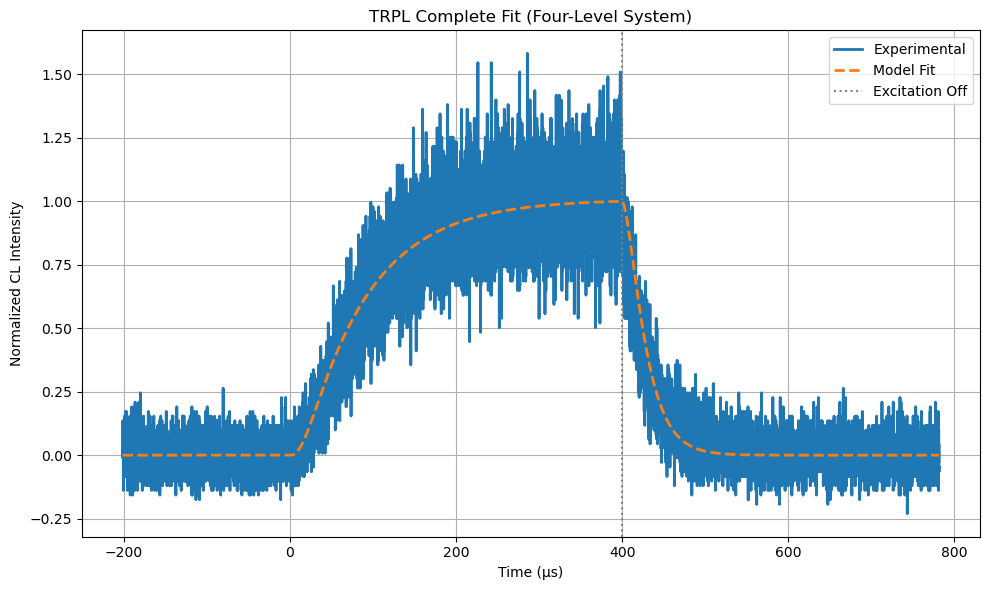

Fit results:
k_exc: 3.6361e-03 µs⁻¹
k_ET: 9.6245e-02 µs⁻¹
k_CL: 2.9355e-03 µs⁻¹
k_relax: 5.0000e-21 µs⁻¹
k_ESA: 4.0115e-02 µs⁻¹
Output saved to: Z:\Jacob\Material YbEr cluster\06122025 YbYb cluster\fit_output_complete_four.csv


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import os

# === USER INPUTS ===
file_path = r"Z:\Jacob\Material YbEr cluster\06122025 YbYb cluster\TRPL_data_raw.csv"
model_type = "four"  # "three" or "four"
fit_mode = "complete"  # "rise", "decay", or "complete"
tau_Yb = 44.29  # µs

# Parameter bounds
initial_guesses = [0.00001, 0.0005, 0.0005, 0,0.00001]  # [k_exc, k_ET, k_CL, k_relax, k_ESA]
lower_bounds = [0.0000001, 0.0000001, 0.0000001, 0, 0.0000001]
upper_bounds = [0.1, 0.1, 0.1, .00000000000000000001, 0.1]

# === Load and normalize data ===
df = pd.read_csv(file_path, skiprows=1)
signal = df.iloc[:, 0].to_numpy()
time = df.iloc[:, 1].to_numpy()

baseline = np.mean(signal[(time >= -200) & (time < -100)])
signal -= baseline
signal /= np.mean(signal[(time >= 350) & (time < 400)])

# === Rate Equations ===
def model_rhs(t, y, k_exc, k_ET, k_CL,k_relax, k_ESA):
    k_Yb = 1 / tau_Yb
    excitation_on = 0 <= t <= 400

    if excitation_on:
        if model_type == "three":
            N0, N1, N2 = y
            dN0 = -k_exc * N0 + k_Yb * N1 + k_CL * N2
            dN1 = k_exc * N0 - k_ESA * N1 + k_relax * N2 - k_Yb * N1
            dN2 = k_ESA * N1 - k_relax * N2 - k_CL * N2
            return [dN0, dN1, dN2]
        else:
            N0, N1, N2, N3 = y
            dN0 = -k_exc * N0 + k_Yb * N1 + k_CL * N3
            dN1 = k_exc * N0 - k_ESA * N1 - k_exc * N1 + k_relax * N2 + 2*k_Yb * N3 - k_Yb * N1
            dN2 = k_ESA * N1 - k_relax * N2 - k_ET * N2
            dN3 = k_ET * N2 + k_exc * N1 - k_CL * N3 - 2*k_Yb * N3
            return [dN0, dN1, dN2, dN3]
    else:
        if model_type == "three":
            N0, N1, N2 = y
            dN0 = k_Yb * N1 + k_CL * N2
            dN1 = k_relax * N2 - k_Yb * N1
            dN2 = -k_relax * N2 - k_CL * N2
            return [dN0, dN1, dN2]
        else:
            N0, N1, N2, N3 = y
            dN0 = k_Yb * N1 + k_CL * N3
            dN1 = k_relax * N2 + 2*k_Yb * N3 - k_Yb * N1
            dN2 = -k_relax * N2 - k_ET * N2
            dN3 = k_ET * N2 - k_CL * N3 - 2*k_Yb * N3
            return [dN0, dN1, dN2, dN3]

# === Solver and fit wrappers ===
def solve_model(t, k_exc, k_ET, k_CL, k_relax, k_ESA, y0=None):
    if y0 is None:
        y0 = [1.0, 0.0, 0.0, 0.0] if model_type == "four" else [1.0, 0.0, 0.0]
    return solve_ivp(model_rhs, [t[0], t[-1]], y0, t_eval=t, args=(k_exc, k_ET, k_CL, k_relax, k_ESA), rtol=1e-8, atol=1e-10)

def model_wrapper(t, k_exc, k_ET, k_CL, k_relax, k_ESA, y0=None):
    sol = solve_model(t, k_exc, k_ET, k_CL, k_relax, k_ESA, y0)
    yout = sol.y[3 if model_type == "four" else 2] * (k_CL if model_type == "three" else k_CL)
    return yout / np.max(yout)

# === Fit region ===
if fit_mode == "rise":
    mask = (time >= 0) & (time <= 400)
elif fit_mode == "decay":
    mask = (time > 400)
else:
    mask = np.full_like(time, True, dtype=bool)

time_fit = time[mask]
signal_fit = signal[mask]

# === Residual functions ===
def residuals_complete(params, t, signal):
    try:
        return model_wrapper(t, *params) - signal
    except Exception:
        return np.full_like(signal, np.inf)

def residuals_decay(params, t, signal, y0_decay, k_exc_fixed):
    try:
        return model_wrapper(t, k_exc_fixed, *params, y0=y0_decay) - signal
    except Exception:
        return np.full_like(signal, np.inf)

# === Multi-start optimization ===
def multi_start_least_squares(res_func, bounds, args, n_trials=100):
    best_loss = np.inf
    best_params = None
    for _ in range(n_trials):
        guess = np.random.uniform(low=bounds[0], high=bounds[1])
        result = least_squares(res_func, guess, bounds=bounds, args=args, max_nfev=20000)
        if result.cost < best_loss:
            best_loss = result.cost
            best_params = result.x
    return best_params

# === Fit procedure using multi-start ===
if fit_mode == "rise":
    popt = multi_start_least_squares(
        residuals_complete,
        (lower_bounds, upper_bounds),
        args=(time_fit, signal_fit),
        n_trials=100
    )

elif fit_mode == "decay":
    # Get steady-state populations at t = 400 µs
    sol_rise = solve_model(np.linspace(0, 400, 500), *initial_guesses)
    y0_decay = sol_rise.y[:, -1]
    k_exc_fixed = initial_guesses[0]
    bounds_decay = (lower_bounds[1:], upper_bounds[1:])

    def decay_res(params, t, signal):
        return residuals_decay(params, t, signal, y0_decay, k_exc_fixed)

    popt_partial = multi_start_least_squares(
        decay_res,
        bounds_decay,
        args=(time_fit, signal_fit),
        n_trials=100
    )
    popt = [k_exc_fixed] + list(popt_partial)

elif fit_mode == "complete":
    popt = multi_start_least_squares(
        residuals_complete,
        (lower_bounds, upper_bounds),
        args=(time_fit, signal_fit),
        n_trials=100
    )
    
# === Simulate final model fit ===
fit_sim = model_wrapper(time_fit, *popt)

# === Plot ===
plt.figure(figsize=(10, 6))
plt.plot(time_fit, signal_fit, label="Experimental", lw=2)
plt.plot(time_fit, fit_sim, '--', label="Model Fit", lw=2)
plt.axvline(400, color='gray', linestyle=':', label="Excitation Off")
plt.xlabel("Time (µs)")
plt.ylabel("Normalized CL Intensity")
plt.title(f"TRPL {fit_mode.capitalize()} Fit ({model_type.capitalize()}-Level System)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Output CSV ===
output_dir = os.path.dirname(file_path)
output_file = os.path.join(output_dir, f"fit_output_{fit_mode}_{model_type}.csv")
header = ", ".join([f"{name}: {val:.4e} µs⁻¹" for name, val in zip(["k_exc", "k_ET", "k_CL", "k_relax", "k_ESA"], popt)])

fit_df = pd.DataFrame({"Time (µs)": time_fit, "Model Fit": fit_sim})
with open(output_file, "w", encoding="utf-8") as f:
    f.write("# " + header + "\n")
    fit_df.to_csv(f, index=False)

# === Print parameters ===
print("Fit results:")
for name, val in zip(["k_exc", "k_ET", "k_CL", "k_relax", "k_ESA"], popt):
    print(f"{name}: {val:.4e} µs⁻¹")
print("Output saved to:", output_file)
